# 01 — Exploratory Data Analysis
Inspect coverage, missingness, correlations.


In [91]:
# Cell 0 — make Python see the src/ package from the notebook folder
import sys, os
from pathlib import Path

# Assuming your notebook is at: project_root/notebooks/01_eda.ipynb
project_root = Path("..").resolve()
sys.path.append(str(project_root / "src"))

# OPTIONAL: autoreload to pick up edits to your modules without restarting kernel
%load_ext autoreload
%autoreload 2

print("Project root:", project_root)
print("CWD:", Path().resolve())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root: C:\edu_health_growth_ml
CWD: C:\edu_health_growth_ml\notebooks


In [92]:
# Cell 1 — quick check that files exist where preprocess.py expects them
from pathlib import Path
raw_csv = project_root / "data" / "raw" / "WB_GS_WIDEF.csv"
config_yaml = project_root / "configs" / "config.yaml"
sel_csv = project_root / "configs" / "selected_indicators.csv"

print("Raw CSV exists:", raw_csv.exists(), raw_csv)
print("Config exists:", config_yaml.exists(), config_yaml)
print("Selected indicators CSV exists:", sel_csv.exists(), sel_csv)

Raw CSV exists: True C:\edu_health_growth_ml\data\raw\WB_GS_WIDEF.csv
Config exists: True C:\edu_health_growth_ml\configs\config.yaml
Selected indicators CSV exists: True C:\edu_health_growth_ml\configs\selected_indicators.csv


In [93]:
# Cell 2 — run pipeline from Python (no CLI) to produce processed parquet + QA CSVs
from preprocess import load_config, run_pipeline

settings = load_config(project_root / "configs" / "config.yaml")

# EDA pass: no scaling for human-readable values
processed_parquet_path = run_pipeline(settings)

processed_parquet_path

=== Preprocessing Pipeline ===
Config: C:\edu_health_growth_ml\configs\config.yaml
Raw CSV: C:\edu_health_growth_ml\data\raw\WB_GS_WIDEF.csv
[Load] Raw shape: (175730, 88)
[Melt] Long shape: (11246720, 8)
[Select] Using curated indicator list with 35 indicators.
[Years] Filtered to 1980-2023, shape: (779504, 8)
[Meta] Wrote country metadata to C:\edu_health_growth_ml\data\processed\country_meta.csv
[Pivot] Panel shape: (11387, 38)
[QA] Saved coverage_by_indicator → C:\edu_health_growth_ml\data\processed\coverage_by_indicator.csv
[QA] Saved coverage_by_country  → C:\edu_health_growth_ml\data\processed\coverage_by_country.csv
[Features] Added lags [1, 3, 5, 10] and deltas [1, 3, 5, 10].
[Features] Final shape: (11387, 318)
[Save] Wrote processed panel → C:\edu_health_growth_ml\data\processed\panel_clean.parquet


WindowsPath('C:/edu_health_growth_ml/data/processed/panel_clean.parquet')

In [94]:
# Cell 3 — load the processed panel
import pandas as pd

panel = pd.read_parquet(processed_parquet_path, engine="fastparquet")
panel.shape, panel.columns[:10]

((11387, 318),
 Index(['REF_AREA', 'REF_AREA_LABEL', 'YEAR', 'WB_GS_NY_GDP_MKTP_CD',
        'WB_GS_NY_GDP_MKTP_KD_ZG', 'WB_GS_NY_GDP_PCAP_KD',
        'WB_GS_NY_GNP_PCAP_PP_CD', 'WB_GS_SE_ADT', 'WB_GS_SE_ADT_1524_LT_FM_ZS',
        'WB_GS_SE_ENR'],
       dtype='object', name='INDICATOR'))

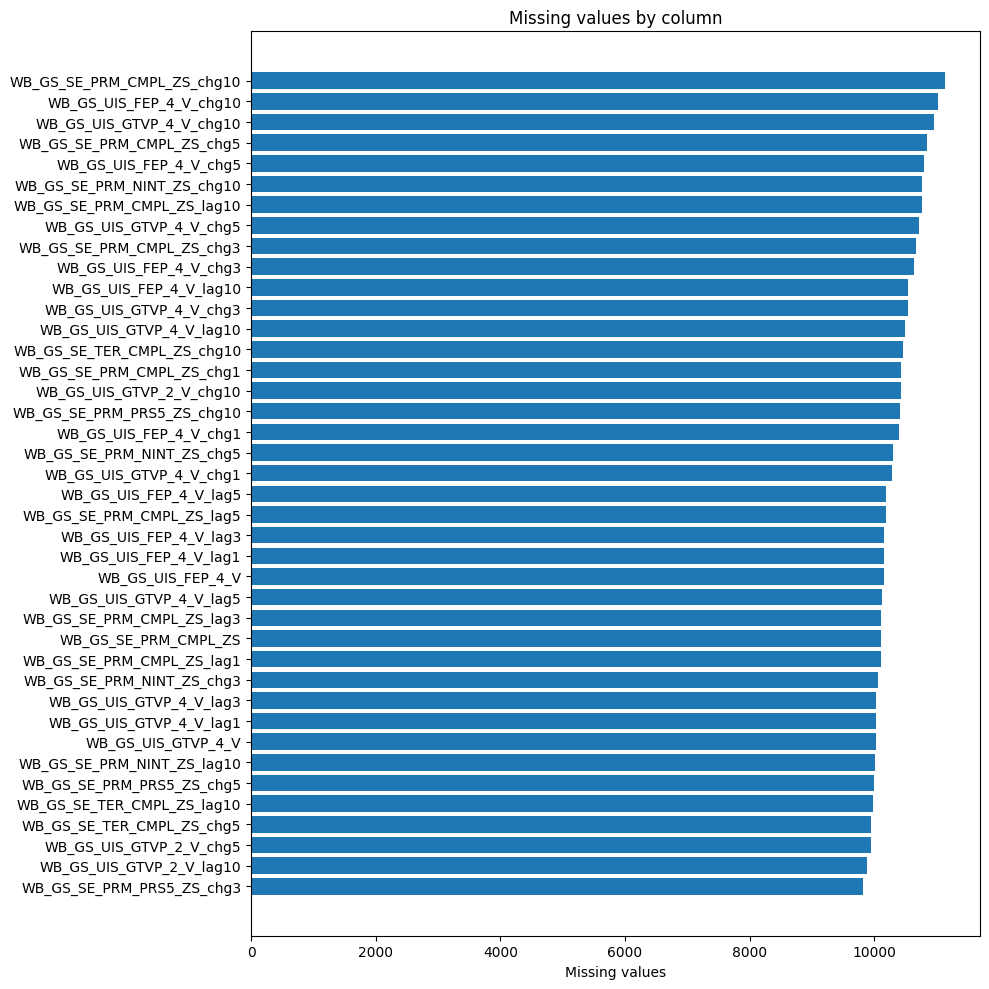

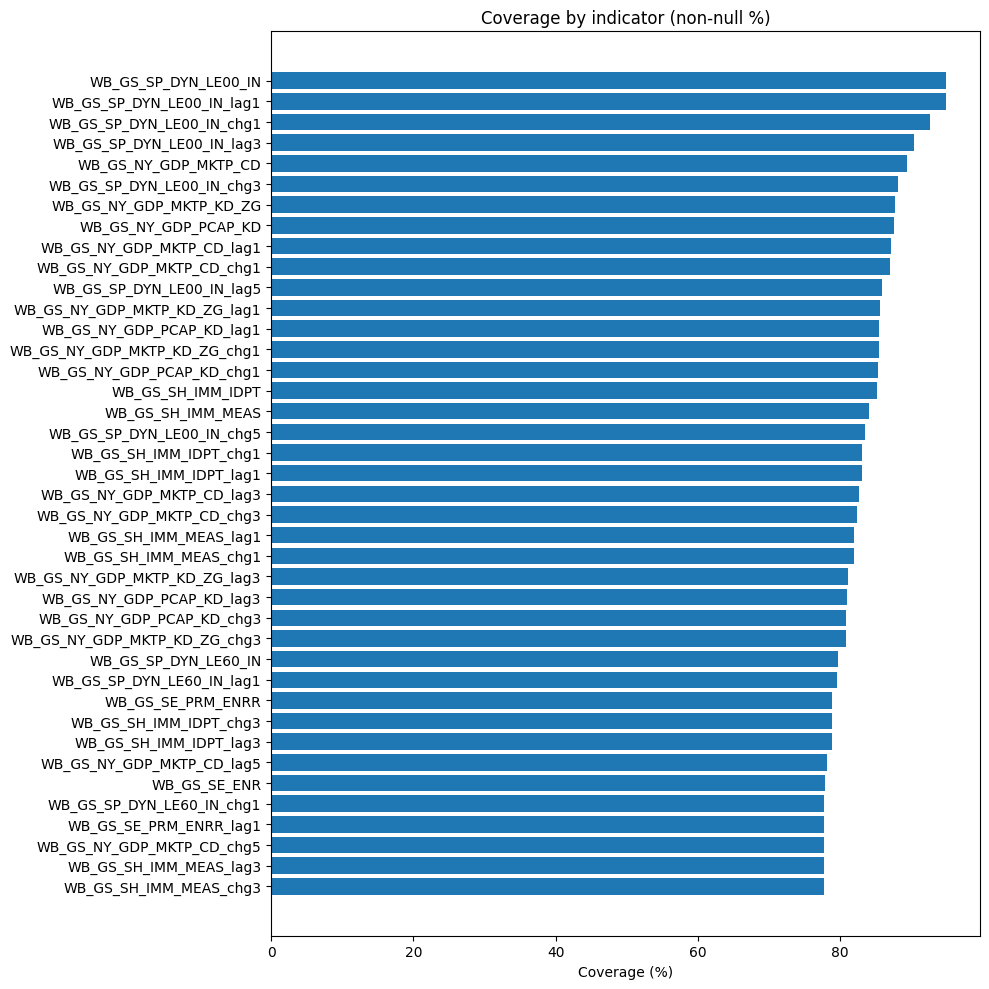

In [95]:
# Cell 4 — import your plotting utilities
from visualization.plots import (
    plot_missing_bar,
    plot_indicator_coverage,
    lineplot_country_timeseries,
    scatter_xy,
    corr_heatmap,
    feature_importance_bar,
)

# Missingness at a glance (top 40 columns with missing values)
plot_missing_bar(panel, top_n=40)

# How complete are indicator columns? (non-null % by indicator)
plot_indicator_coverage(panel, top_n=40)

In [96]:
# Cell 5 — build a code ↔ label dictionary from the raw file
raw = pd.read_csv(project_root / "data" / "raw" / "WB_GS_WIDEF.csv")
meta_cols = [c for c in ["INDICATOR", "INDICATOR_LABEL"] if c in raw.columns]
code2label = (
    raw[meta_cols]
    .drop_duplicates()
    .set_index("INDICATOR")["INDICATOR_LABEL"]
    .to_dict()
)

def find_indicators(containing: str, max_show=20):
    containing_low = containing.lower()
    hits = [c for c in panel.columns if c not in ("REF_AREA","REF_AREA_LABEL","YEAR") and containing_low in c.lower()]
    # also try on labels
    hits_by_label = [code for code,label in code2label.items() if containing_low in str(label).lower() and code in panel.columns]
    # merge unique while preserving order
    seen = set()
    merged = []
    for h in hits + hits_by_label:
        if h not in seen:
            merged.append(h); seen.add(h)
    for code in merged[:max_show]:
        print(code, "—", code2label.get(code, "(no label)"))
    return merged

print("GDP growth candidates:")
_ = find_indicators("gdp growth")

print("\nEducation candidates:")
_ = find_indicators("school") or find_indicators("education") or find_indicators("enrol")

print("\nHealth candidates:")
_ = find_indicators("life expectancy") or find_indicators("mortality") or find_indicators("health exp")

GDP growth candidates:
WB_GS_NY_GDP_MKTP_KD_ZG — GDP growth (annual %)

Education candidates:
WB_GS_SE_ENR — School enrollment, gender parity index
WB_GS_SE_PRE_ENRR — School enrollment, preprimary (% gross)
WB_GS_SE_PRM_ENRR — School enrollment, primary (%)
WB_GS_SE_PRM_NINT_ZS — Net intake rate in grade 1 (% of official school-age population)
WB_GS_SE_SCH_LIFE — Expected years of schooling
WB_GS_SE_SEC_ENRR — School enrollment, secondary (%)
WB_GS_SE_TER_ENRR — School enrollment, tertiary (% gross)

Health candidates:
WB_GS_SP_DYN_LE00_IN — Life expectancy at birth (years)
WB_GS_SP_DYN_LE60_IN — Life expectancy at age 60 (years)


In [97]:
# Cell 6 — choose your working indicators based on the printed candidates
GDP_GROWTH = "WB_GS_NY_GDP_MKTP_KD_ZG"  # <- replace if your code is different
EDU_MAIN   = "WB_GS_SE_TER_ENRR"        # Tertiary school enrollment, gross (%)
HEALTH_MAIN= "WB_GS_SP_DYN_LE00_IN"     # Life expectancy at birth, total (years)

# Verify they exist
for c in [GDP_GROWTH, EDU_MAIN, HEALTH_MAIN]:
    assert c in panel.columns, f"Column not found: {c}"
    print(c, "—", code2label.get(c, "(no label)"))

WB_GS_NY_GDP_MKTP_KD_ZG — GDP growth (annual %)
WB_GS_SE_TER_ENRR — School enrollment, tertiary (% gross)
WB_GS_SP_DYN_LE00_IN — Life expectancy at birth (years)


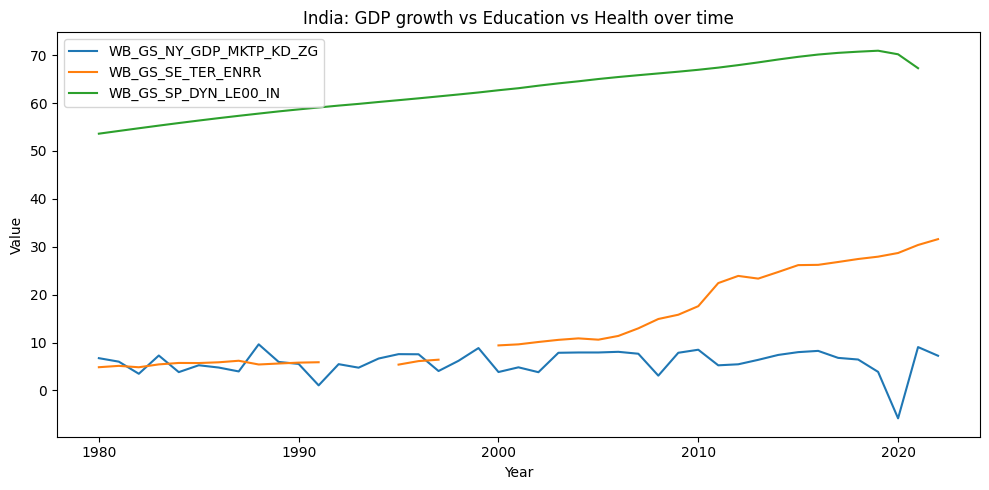

In [98]:
# Cell 7 — time series for one country (no scaling edition for readability)
lineplot_country_timeseries(
    panel_df=panel,
    country="India",                                 # change as you like
    columns=[GDP_GROWTH, EDU_MAIN, HEALTH_MAIN],
    title="India: GDP growth vs Education vs Health over time",
    save_as="india_timeseries.png"
)

In [99]:
# Cell 8 — get the “latest” row per country with non-null on chosen features
features_needed = [GDP_GROWTH, f"{EDU_MAIN}_lag3", f"{HEALTH_MAIN}_lag3"]
snap = (
    panel.dropna(subset=features_needed)
    .sort_values(["REF_AREA", "YEAR"])
    .groupby("REF_AREA", as_index=False)
    .tail(1)   # the last year available per country
)

snap.shape
snap[["REF_AREA_LABEL","YEAR"] + features_needed].head()

INDICATOR,REF_AREA_LABEL,YEAR,WB_GS_NY_GDP_MKTP_KD_ZG,WB_GS_SE_TER_ENRR_lag3,WB_GS_SP_DYN_LE00_IN_lag3
39,Aruba,2019,-2.302837,18.510773,75.561667
85,Africa Eastern and Southern,2022,3.435138,8.809880,63.755375
127,Afghanistan,2021,-20.738839,9.899566,63.154000
171,Africa Western and Central,2022,3.766354,9.874247,57.559722
214,Angola,2022,3.045403,11.063261,62.449000


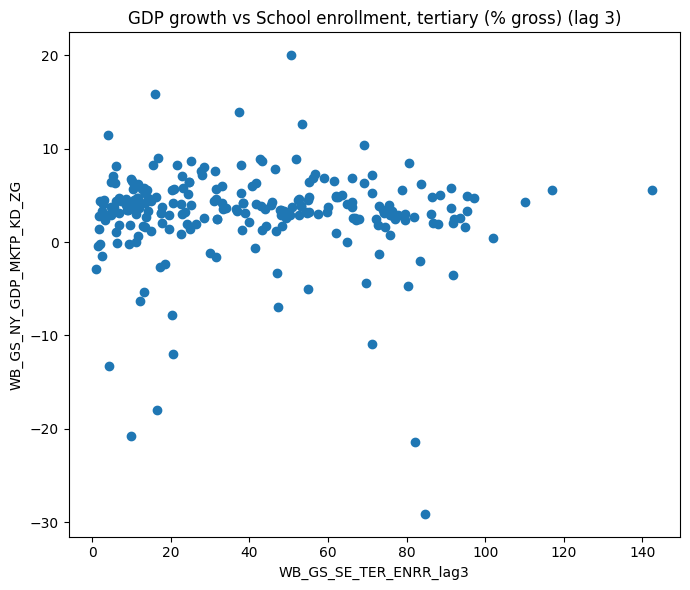

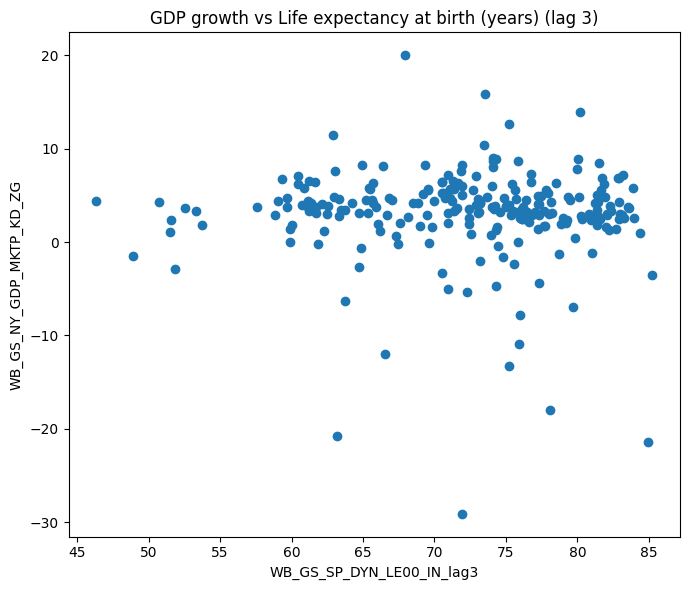

In [100]:
# Cell 9 — scatter plots with labels (limited annotation if < 150 points)
scatter_xy(
    df=snap,
    x=f"{EDU_MAIN}_lag3",
    y=GDP_GROWTH,
    annotate="REF_AREA_LABEL",
    title=f"GDP growth vs {code2label.get(EDU_MAIN,'EDU')} (lag 3)",
    save_as="gdp_vs_edu_lag3.png"
)

scatter_xy(
    df=snap,
    x=f"{HEALTH_MAIN}_lag3",
    y=GDP_GROWTH,
    annotate="REF_AREA_LABEL",
    title=f"GDP growth vs {code2label.get(HEALTH_MAIN,'HEALTH')} (lag 3)",
    save_as="gdp_vs_health_lag3.png"
)

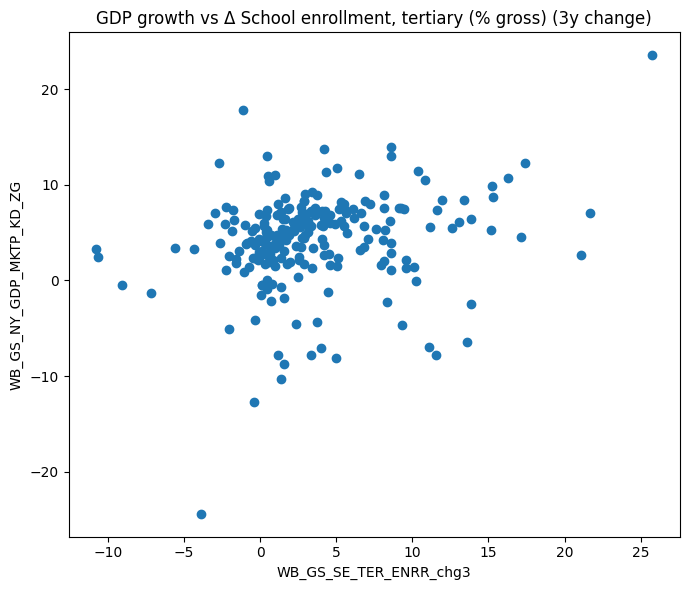

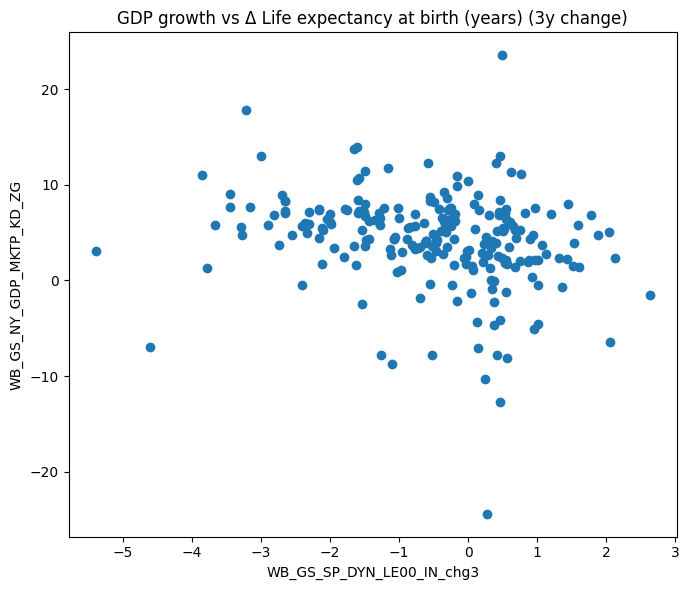

In [101]:
# Cell 10 — where changes in inputs align with growth
chg_cols = [f"{EDU_MAIN}_chg3", f"{HEALTH_MAIN}_chg3", GDP_GROWTH]
snap_chg = (
    panel.dropna(subset=chg_cols)
    .sort_values(["REF_AREA","YEAR"])
    .groupby("REF_AREA", as_index=False)
    .tail(1)
)

scatter_xy(
    df=snap_chg,
    x=f"{EDU_MAIN}_chg3",
    y=GDP_GROWTH,
    annotate=None,
    title=f"GDP growth vs Δ {code2label.get(EDU_MAIN,'EDU')} (3y change)",
    save_as="gdp_vs_edu_chg3.png"
)

scatter_xy(
    df=snap_chg,
    x=f"{HEALTH_MAIN}_chg3",
    y=GDP_GROWTH,
    annotate=None,
    title=f"GDP growth vs Δ {code2label.get(HEALTH_MAIN,'HEALTH')} (3y change)",
    save_as="gdp_vs_health_chg3.png"
)


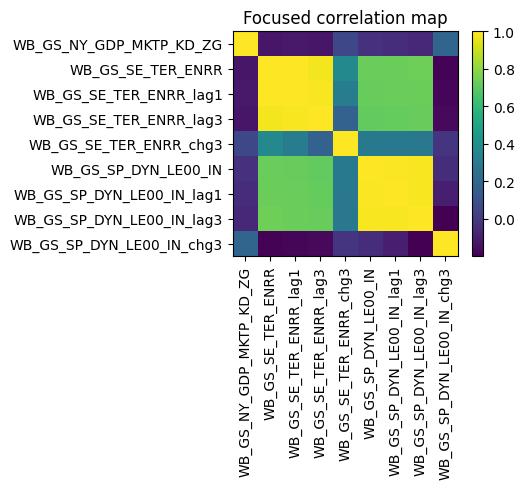

In [102]:
# Cell 11 — focused correlation panel
cols_for_corr = [
    GDP_GROWTH,
    EDU_MAIN, f"{EDU_MAIN}_lag1", f"{EDU_MAIN}_lag3", f"{EDU_MAIN}_chg3",
    HEALTH_MAIN, f"{HEALTH_MAIN}_lag1", f"{HEALTH_MAIN}_lag3", f"{HEALTH_MAIN}_chg3",
]
cols_for_corr = [c for c in cols_for_corr if c in panel.columns]
corr_heatmap(panel, cols=cols_for_corr, method="pearson", title="Focused correlation map")

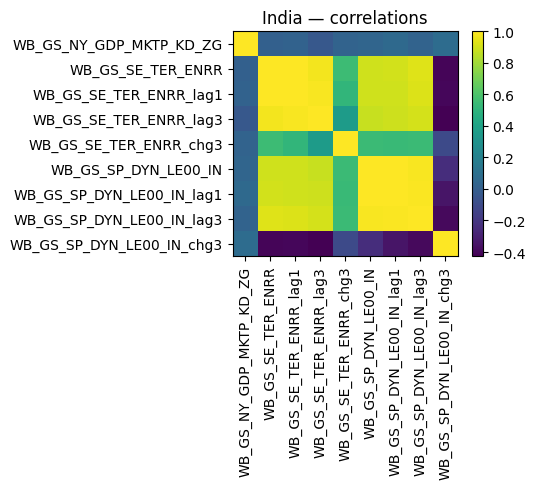

In [103]:
india = panel[panel["REF_AREA_LABEL"] == "India"]
corr_heatmap(india, cols=cols_for_corr, title="India — correlations")

In [104]:
# Cell 12 — rank countries by Δ education/health and their growth (last available year)
ranking = (
    panel.dropna(subset=[f"{EDU_MAIN}_chg3", f"{HEALTH_MAIN}_chg3", GDP_GROWTH])
    .sort_values(["REF_AREA","YEAR"])
    .groupby(["REF_AREA","REF_AREA_LABEL"], as_index=False)
    .tail(1)[["REF_AREA","REF_AREA_LABEL", f"{EDU_MAIN}_chg3", f"{HEALTH_MAIN}_chg3", GDP_GROWTH]]
    .rename(columns={
        f"{EDU_MAIN}_chg3":"edu_chg3",
        f"{HEALTH_MAIN}_chg3":"health_chg3",
        GDP_GROWTH:"gdp_growth"
    })
)

ranking.sort_values("edu_chg3", ascending=False).head(10)
ranking.sort_values("health_chg3", ascending=False).head(10)
ranking.sort_values("gdp_growth", ascending=False).head(10)

INDICATOR,REF_AREA,REF_AREA_LABEL,edu_chg3,health_chg3,gdp_growth
6271,MAC,"Macao SAR, China",25.753891,0.484667,23.535567
1159,BLZ,Belize,-1.117673,-3.214333,17.862448
6442,MDA,Moldova,8.580949,-1.603000,13.930000
4295,HRV,Croatia,4.184556,-1.648780,13.784947
6958,MNE,Montenegro,0.434099,-3.005691,13.043464
5652,LBY,Libya,8.624671,0.455333,13.016037
6829,MLT,Malta,17.408802,0.404065,12.297967
2577,DOM,Dominican Republic,-2.690500,-0.586667,12.271990
1717,CHL,Chile,5.049932,-1.163667,11.737431
10483,TUR,Turkiye,10.404195,-1.490333,11.439385


In [105]:
# Cell 13 — scaled pass for modeling (unit-free, useful for feature importances)
processed_scaled = run_pipeline(settings)
scaled_panel = pd.read_parquet(processed_scaled, engine="fastparquet")
scaled_panel.shape 

=== Preprocessing Pipeline ===
Config: C:\edu_health_growth_ml\configs\config.yaml
Raw CSV: C:\edu_health_growth_ml\data\raw\WB_GS_WIDEF.csv
[Load] Raw shape: (175730, 88)
[Melt] Long shape: (11246720, 8)
[Select] Using curated indicator list with 35 indicators.
[Years] Filtered to 1980-2023, shape: (779504, 8)
[Meta] Wrote country metadata to C:\edu_health_growth_ml\data\processed\country_meta.csv
[Pivot] Panel shape: (11387, 38)
[QA] Saved coverage_by_indicator → C:\edu_health_growth_ml\data\processed\coverage_by_indicator.csv
[QA] Saved coverage_by_country  → C:\edu_health_growth_ml\data\processed\coverage_by_country.csv
[Features] Added lags [1, 3, 5, 10] and deltas [1, 3, 5, 10].
[Features] Final shape: (11387, 318)
[Save] Wrote processed panel → C:\edu_health_growth_ml\data\processed\panel_clean.parquet


(11387, 318)

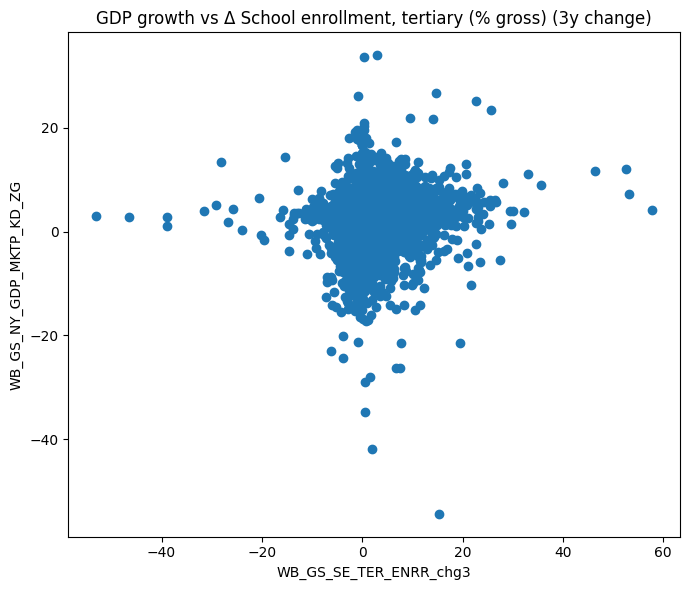

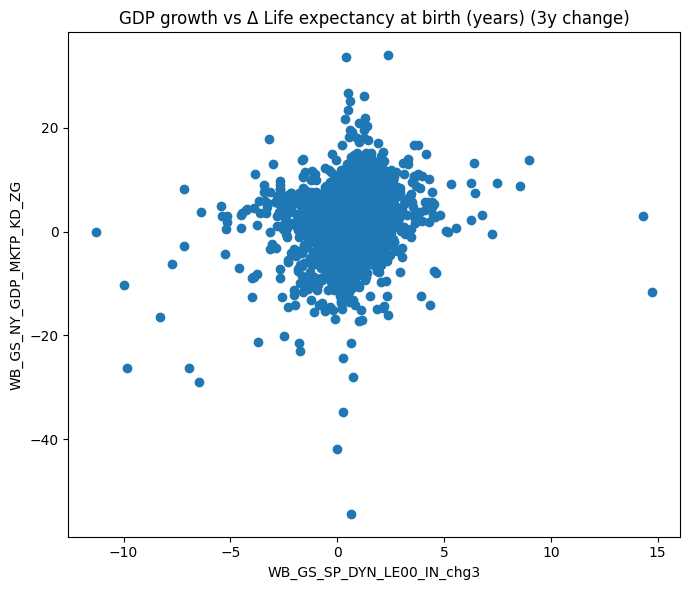

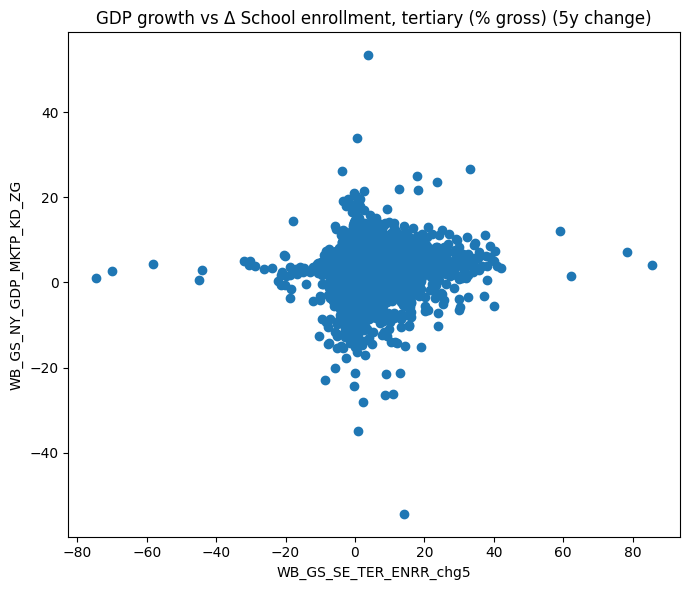

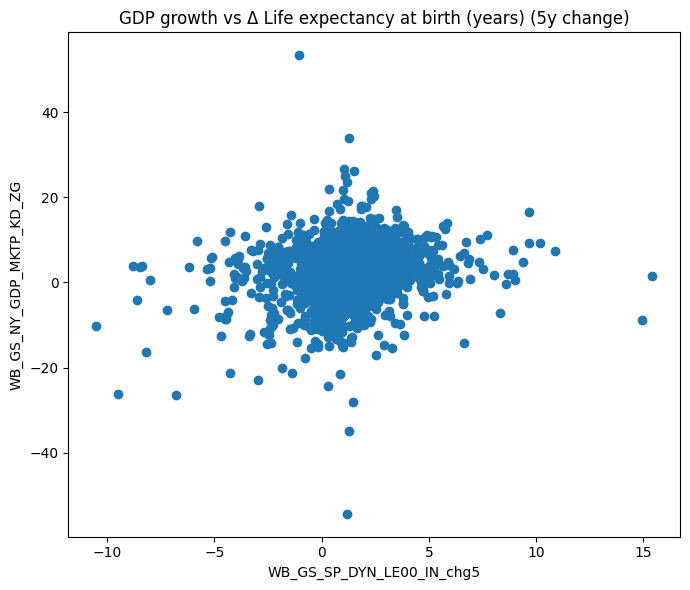

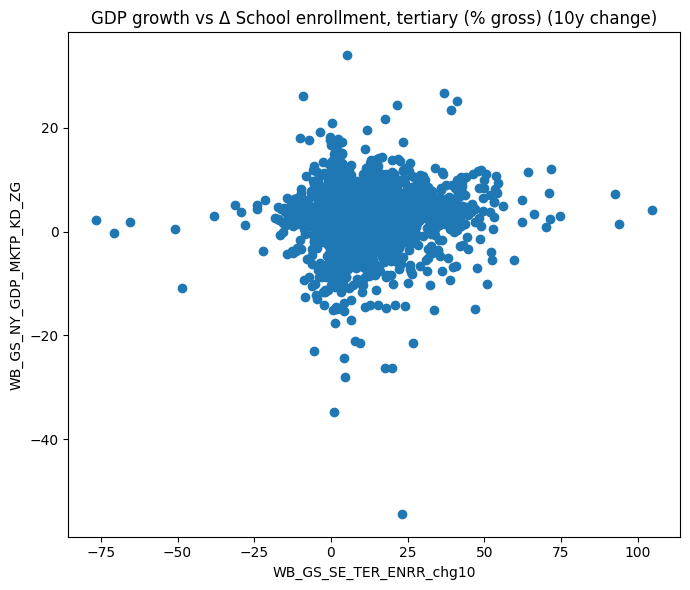

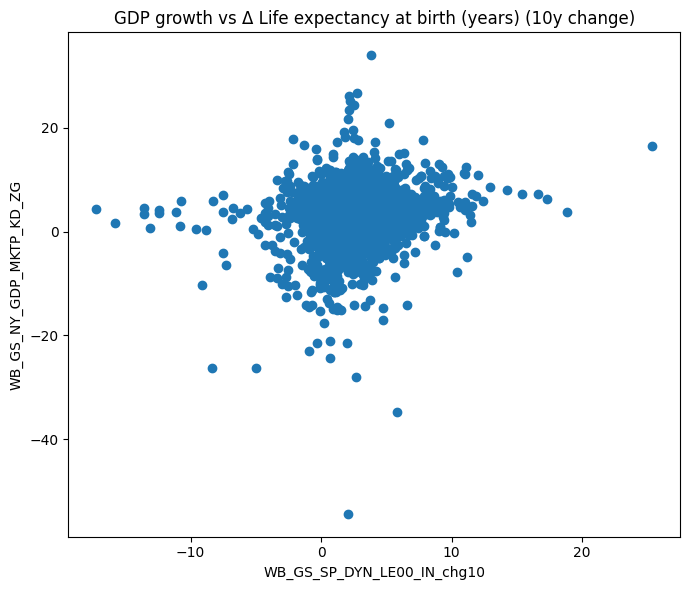

In [106]:
# Cell 14 — where changes in inputs align with growth (multi-horizon)
lags = [3, 5, 10]

for lag in lags:
    # Define the columns we care about
    chg_cols = [f"{EDU_MAIN}_chg{lag}", f"{HEALTH_MAIN}_chg{lag}", GDP_GROWTH]

    # Keep all valid rows (don’t just tail(1)!)
    snap_chg = (
        panel.dropna(subset=chg_cols)
        .sort_values(["REF_AREA", "YEAR"])
    )

    # Education vs GDP growth
    scatter_xy(
        df=snap_chg,
        x=f"{EDU_MAIN}_chg{lag}",
        y=GDP_GROWTH,
        annotate=None,
        title=f"GDP growth vs Δ {code2label.get(EDU_MAIN,'EDU')} ({lag}y change)",
        save_as=f"gdp_vs_edu_chg{lag}.png"
    )

    # Health vs GDP growth
    scatter_xy(
        df=snap_chg,
        x=f"{HEALTH_MAIN}_chg{lag}",
        y=GDP_GROWTH,
        annotate=None,
        title=f"GDP growth vs Δ {code2label.get(HEALTH_MAIN,'HEALTH')} ({lag}y change)",
        save_as=f"gdp_vs_health_chg{lag}.png"
    )


In [107]:
print([col for col in scaled_panel.columns if "chg" in col])

['WB_GS_NY_GDP_MKTP_CD_chg1', 'WB_GS_NY_GDP_MKTP_KD_ZG_chg1', 'WB_GS_NY_GDP_PCAP_KD_chg1', 'WB_GS_NY_GNP_PCAP_PP_CD_chg1', 'WB_GS_SE_ADT_chg1', 'WB_GS_SE_ADT_1524_LT_FM_ZS_chg1', 'WB_GS_SE_ENR_chg1', 'WB_GS_SE_PRE_ENRR_chg1', 'WB_GS_SE_PRM_CMPL_ZS_chg1', 'WB_GS_SE_PRM_CMPT_ZS_chg1', 'WB_GS_SE_PRM_ENRL_FE_ZS_chg1', 'WB_GS_SE_PRM_ENRR_chg1', 'WB_GS_SE_PRM_GINT_ZS_chg1', 'WB_GS_SE_PRM_NINT_ZS_chg1', 'WB_GS_SE_PRM_PRS5_ZS_chg1', 'WB_GS_SE_PRM_TCHR_FE_ZS_chg1', 'WB_GS_SE_SCH_LIFE_chg1', 'WB_GS_SE_SEC_ENRL_FE_ZS_chg1', 'WB_GS_SE_SEC_ENRL_MA_VO_ZS_chg1', 'WB_GS_SE_SEC_ENRL_VO_chg1', 'WB_GS_SE_SEC_ENRL_VO_FE_ZS_chg1', 'WB_GS_SE_SEC_ENRR_chg1', 'WB_GS_SE_SEC_TCHR_FE_ZS_chg1', 'WB_GS_SE_TER_CMPL_ZS_chg1', 'WB_GS_SE_TER_ENRR_chg1', 'WB_GS_SE_TER_TCHR_FE_ZS_chg1', 'WB_GS_SH_IMM_IDPT_chg1', 'WB_GS_SH_IMM_MEAS_chg1', 'WB_GS_SH_STA_MMRT_chg1', 'WB_GS_SP_DYN_LE00_IN_chg1', 'WB_GS_SP_DYN_LE60_IN_chg1', 'WB_GS_UIS_FEP_4_V_chg1', 'WB_GS_UIS_GTVP_2_V_chg1', 'WB_GS_UIS_GTVP_3_V_chg1', 'WB_GS_UIS_GTVP_4_V_c

In [108]:
[col for col in scaled_panel.columns if "chg10" in col]


['WB_GS_NY_GDP_MKTP_CD_chg10',
 'WB_GS_NY_GDP_MKTP_KD_ZG_chg10',
 'WB_GS_NY_GDP_PCAP_KD_chg10',
 'WB_GS_NY_GNP_PCAP_PP_CD_chg10',
 'WB_GS_SE_ADT_chg10',
 'WB_GS_SE_ADT_1524_LT_FM_ZS_chg10',
 'WB_GS_SE_ENR_chg10',
 'WB_GS_SE_PRE_ENRR_chg10',
 'WB_GS_SE_PRM_CMPL_ZS_chg10',
 'WB_GS_SE_PRM_CMPT_ZS_chg10',
 'WB_GS_SE_PRM_ENRL_FE_ZS_chg10',
 'WB_GS_SE_PRM_ENRR_chg10',
 'WB_GS_SE_PRM_GINT_ZS_chg10',
 'WB_GS_SE_PRM_NINT_ZS_chg10',
 'WB_GS_SE_PRM_PRS5_ZS_chg10',
 'WB_GS_SE_PRM_TCHR_FE_ZS_chg10',
 'WB_GS_SE_SCH_LIFE_chg10',
 'WB_GS_SE_SEC_ENRL_FE_ZS_chg10',
 'WB_GS_SE_SEC_ENRL_MA_VO_ZS_chg10',
 'WB_GS_SE_SEC_ENRL_VO_chg10',
 'WB_GS_SE_SEC_ENRL_VO_FE_ZS_chg10',
 'WB_GS_SE_SEC_ENRR_chg10',
 'WB_GS_SE_SEC_TCHR_FE_ZS_chg10',
 'WB_GS_SE_TER_CMPL_ZS_chg10',
 'WB_GS_SE_TER_ENRR_chg10',
 'WB_GS_SE_TER_TCHR_FE_ZS_chg10',
 'WB_GS_SH_IMM_IDPT_chg10',
 'WB_GS_SH_IMM_MEAS_chg10',
 'WB_GS_SH_STA_MMRT_chg10',
 'WB_GS_SP_DYN_LE00_IN_chg10',
 'WB_GS_SP_DYN_LE60_IN_chg10',
 'WB_GS_UIS_FEP_4_V_chg10',
 'WB_GS_UIS_

In [112]:
from pathlib import Path

data_path = Path("data/processed/panel_clean.parquet")
print(data_path.resolve())  # just to check


C:\edu_health_growth_ml\notebooks\data\processed\panel_clean.parquet


In [127]:
import pandas as pd
from sklearn.metrics import root_mean_squared_error, r2_score
import joblib  # if you saved your model with joblib/pickle
from pathlib import Path

# 1. Load processed data
data_path = Path("C:/edu_health_growth_ml/data/processed/panel_clean.parquet")

df_1 = pd.read_parquet(data_path, engine="fastparquet")

print("Shape:", df_1.shape)

# View the first 5 rows
display(df_1.tail(44))


print(df_1.columns.tolist())

Shape: (11387, 318)


INDICATOR,REF_AREA,REF_AREA_LABEL,YEAR,WB_GS_NY_GDP_MKTP_CD,WB_GS_NY_GDP_MKTP_KD_ZG,WB_GS_NY_GDP_PCAP_KD,WB_GS_NY_GNP_PCAP_PP_CD,WB_GS_SE_ADT,WB_GS_SE_ADT_1524_LT_FM_ZS,WB_GS_SE_ENR,...,WB_GS_SE_TER_TCHR_FE_ZS_chg10,WB_GS_SH_IMM_IDPT_chg10,WB_GS_SH_IMM_MEAS_chg10,WB_GS_SH_STA_MMRT_chg10,WB_GS_SP_DYN_LE00_IN_chg10,WB_GS_SP_DYN_LE60_IN_chg10,WB_GS_UIS_FEP_4_V_chg10,WB_GS_UIS_GTVP_2_V_chg10,WB_GS_UIS_GTVP_3_V_chg10,WB_GS_UIS_GTVP_4_V_chg10
11343,ZMB,Zambia,2022,2.916378e+10,5.249622,1308.101838,3980.0,NaN,NaN,NaN,...,NaN,4.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11344,ZWE,Zimbabwe,1980,6.678868e+09,14.420684,1537.130656,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11345,ZWE,Zimbabwe,1981,8.011374e+09,12.525425,1624.452476,NaN,NaN,NaN,0.856517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11346,ZWE,Zimbabwe,1982,8.539701e+09,2.634297,1603.722879,NaN,83.580629,0.903920,0.847307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11347,ZWE,Zimbabwe,1983,7.764067e+09,1.585305,1568.352696,NaN,NaN,NaN,0.752070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11348,ZWE,Zimbabwe,1984,6.352126e+09,-1.907360,1484.911732,NaN,NaN,NaN,0.753582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11349,ZWE,Zimbabwe,1985,5.637259e+09,6.944388,1534.681701,NaN,NaN,NaN,0.843937,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11350,ZWE,Zimbabwe,1986,6.217524e+09,2.099029,1515.869845,NaN,NaN,NaN,0.754173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11351,ZWE,Zimbabwe,1987,6.741215e+09,1.150737,1484.650031,NaN,NaN,NaN,0.867157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11352,ZWE,Zimbabwe,1988,7.814784e+09,7.552375,1548.174062,NaN,NaN,NaN,0.874883,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


['REF_AREA', 'REF_AREA_LABEL', 'YEAR', 'WB_GS_NY_GDP_MKTP_CD', 'WB_GS_NY_GDP_MKTP_KD_ZG', 'WB_GS_NY_GDP_PCAP_KD', 'WB_GS_NY_GNP_PCAP_PP_CD', 'WB_GS_SE_ADT', 'WB_GS_SE_ADT_1524_LT_FM_ZS', 'WB_GS_SE_ENR', 'WB_GS_SE_PRE_ENRR', 'WB_GS_SE_PRM_CMPL_ZS', 'WB_GS_SE_PRM_CMPT_ZS', 'WB_GS_SE_PRM_ENRL_FE_ZS', 'WB_GS_SE_PRM_ENRR', 'WB_GS_SE_PRM_GINT_ZS', 'WB_GS_SE_PRM_NINT_ZS', 'WB_GS_SE_PRM_PRS5_ZS', 'WB_GS_SE_PRM_TCHR_FE_ZS', 'WB_GS_SE_SCH_LIFE', 'WB_GS_SE_SEC_ENRL_FE_ZS', 'WB_GS_SE_SEC_ENRL_MA_VO_ZS', 'WB_GS_SE_SEC_ENRL_VO', 'WB_GS_SE_SEC_ENRL_VO_FE_ZS', 'WB_GS_SE_SEC_ENRR', 'WB_GS_SE_SEC_TCHR_FE_ZS', 'WB_GS_SE_TER_CMPL_ZS', 'WB_GS_SE_TER_ENRR', 'WB_GS_SE_TER_TCHR_FE_ZS', 'WB_GS_SH_IMM_IDPT', 'WB_GS_SH_IMM_MEAS', 'WB_GS_SH_STA_MMRT', 'WB_GS_SP_DYN_LE00_IN', 'WB_GS_SP_DYN_LE60_IN', 'WB_GS_UIS_FEP_4_V', 'WB_GS_UIS_GTVP_2_V', 'WB_GS_UIS_GTVP_3_V', 'WB_GS_UIS_GTVP_4_V', 'WB_GS_NY_GDP_MKTP_CD_lag1', 'WB_GS_NY_GDP_MKTP_KD_ZG_lag1', 'WB_GS_NY_GDP_PCAP_KD_lag1', 'WB_GS_NY_GNP_PCAP_PP_CD_lag1', 'WB_GS_SE

In [2]:
import pandas as pd
from sklearn.metrics import root_mean_squared_error, r2_score
import joblib  # if you saved your model with joblib/pickle
from pathlib import Path

# 1. Load processed data
data_path = Path("C:/edu_health_growth_ml/data/raw/WB_GS_WIDEF.csv")
df_1 = pd.read_csv(data_path)

print("Shape:", df_1.shape)

# View the first 5 rows
display(df_1.tail(44))


print(df_1.columns.tolist())

Shape: (175730, 88)


,FREQ,FREQ_LABEL,REF_AREA,REF_AREA_LABEL,INDICATOR,INDICATOR_LABEL,SEX,SEX_LABEL,AGE,AGE_LABEL,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
175686,A,Annual,ZWE,Zimbabwe,WB_GS_SP_POP_BRTH_MF,Sex ratio at birth (male births per female bir...,_T,Total,_T,All age ranges or no breakdown by age,...,1.020000,1.021000,1.021000,1.022000,1.023000,1.023000,1.024000,1.024000,NaN,NaN
175687,A,Annual,ZWE,Zimbabwe,WB_GS_SP_POP_DPND,Age dependency ratio (% of working-age populat...,_T,Total,_T,All age ranges or no breakdown by age,...,85.875504,85.083365,84.112216,83.101286,82.123347,81.207858,80.285255,79.393577,78.430760,NaN
175688,A,Annual,ZWE,Zimbabwe,WB_GS_SP_POP_INT,"Age population, interpolated",F,Female,Y0,under 1 year old,...,234669.500000,232241.000000,230619.500000,230478.000000,231364.500000,232437.500000,233121.500000,234107.500000,235193.500000,NaN
175689,A,Annual,ZWE,Zimbabwe,WB_GS_SP_POP_INT,"Age population, interpolated",F,Female,Y1,1 year old,...,231035.000000,231143.500000,228887.500000,227427.500000,227414.000000,228370.500000,229633.500000,230625.000000,231710.500000,NaN
175690,A,Annual,ZWE,Zimbabwe,WB_GS_SP_POP_INT,"Age population, interpolated",F,Female,Y2,2 years old,...,226452.000000,228890.500000,229070.500000,226899.000000,225509.000000,225529.500000,226649.000000,228181.000000,229279.000000,NaN
175691,A,Annual,ZWE,Zimbabwe,WB_GS_SP_POP_INT,"Age population, interpolated",F,Female,Y3,3 years old,...,220536.000000,225066.000000,227538.500000,227761.500000,225637.000000,224272.500000,224410.000000,225713.000000,227316.000000,NaN
175692,A,Annual,ZWE,Zimbabwe,WB_GS_SP_POP_INT,"Age population, interpolated",F,Female,Y4,4 years old,...,213229.000000,219664.000000,224209.000000,226702.500000,226949.500000,224842.000000,223547.500000,223779.500000,225112.500000,NaN
175693,A,Annual,ZWE,Zimbabwe,WB_GS_SP_POP_INT,"Age population, interpolated",F,Female,Y5,5 years old,...,204123.500000,212668.000000,219108.000000,223661.000000,226166.500000,226420.000000,224351.500000,223099.000000,223338.500000,NaN
175694,A,Annual,ZWE,Zimbabwe,WB_GS_SP_POP_INT,"Age population, interpolated",M,Male,Y0,under 1 year old,...,237855.500000,235519.500000,234010.000000,234043.000000,235159.000000,236406.500000,237218.500000,238336.000000,239533.000000,NaN
175695,A,Annual,ZWE,Zimbabwe,WB_GS_SP_POP_INT,"Age population, interpolated",M,Male,Y1,1 year old,...,233228.500000,233470.500000,231324.500000,229994.500000,230173.000000,231377.000000,232991.500000,234449.500000,235829.000000,NaN


['FREQ', 'FREQ_LABEL', 'REF_AREA', 'REF_AREA_LABEL', 'INDICATOR', 'INDICATOR_LABEL', 'SEX', 'SEX_LABEL', 'AGE', 'AGE_LABEL', 'UNIT_MEASURE', 'UNIT_MEASURE_LABEL', 'COMP_BREAKDOWN_1', 'COMP_BREAKDOWN_1_LABEL', 'COMP_BREAKDOWN_2', 'COMP_BREAKDOWN_2_LABEL', 'DATABASE_ID', 'DATABASE_ID_LABEL', 'UNIT_MULT', 'UNIT_MULT_LABEL', 'OBS_STATUS', 'OBS_STATUS_LABEL', 'OBS_CONF', 'OBS_CONF_LABEL', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']


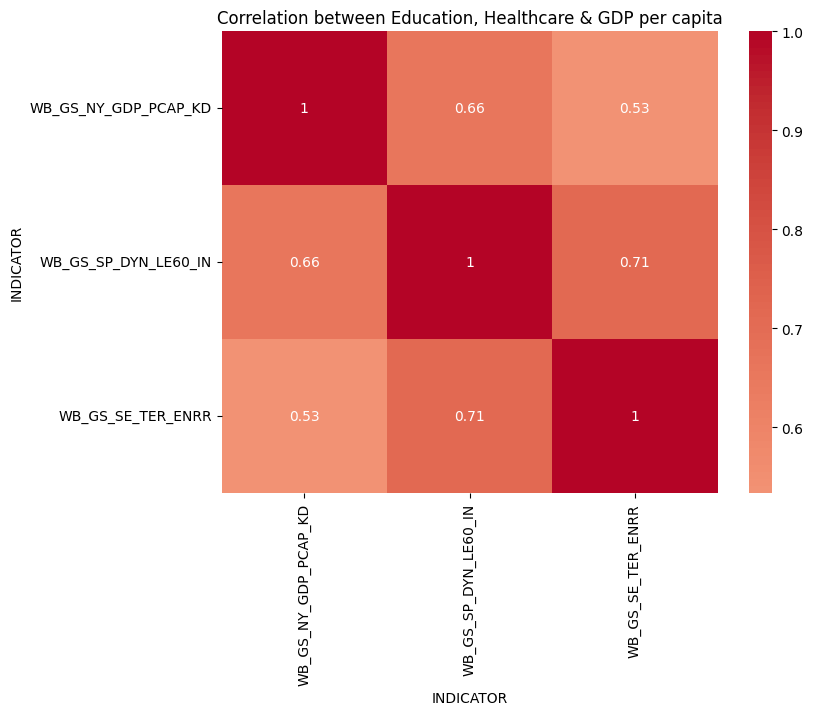

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load your data
data_path1 = Path("C:/edu_health_growth_ml/data/processed/panel_clean.parquet")
df = pd.read_parquet(data_path1)

# Select only GDP growth + education + healthcare columns
subset = df[["WB_GS_NY_GDP_PCAP_KD", "WB_GS_SP_DYN_LE60_IN", "WB_GS_SE_TER_ENRR"]]  

# Correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(subset.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Education, Healthcare & GDP per capita")
plt.show()

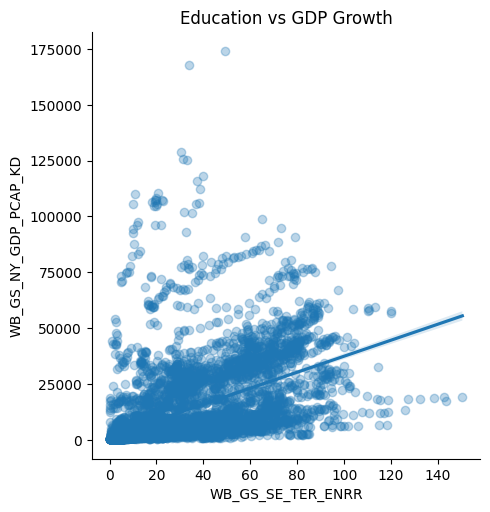

In [7]:
sns.lmplot(
    data=df, 
    x="WB_GS_SE_TER_ENRR", 
    y="WB_GS_NY_GDP_PCAP_KD",
    scatter_kws={'alpha':0.3}
)
plt.title("Education vs GDP Growth")
plt.show()

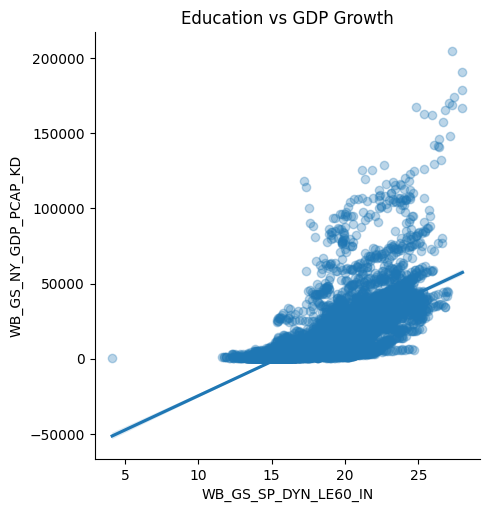

In [8]:
sns.lmplot(
    data=df, 
    x="WB_GS_SP_DYN_LE60_IN", 
    y="WB_GS_NY_GDP_PCAP_KD",
    scatter_kws={'alpha':0.3}
)
plt.title("Education vs GDP Growth")
plt.show()

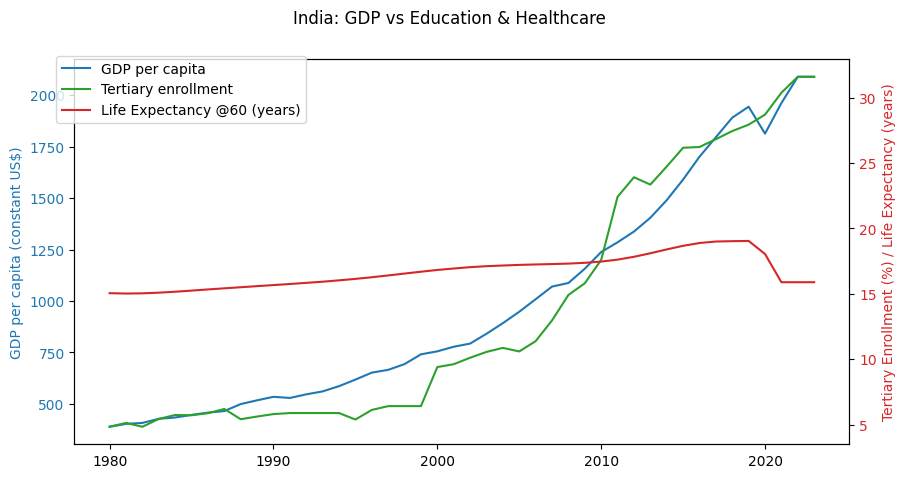

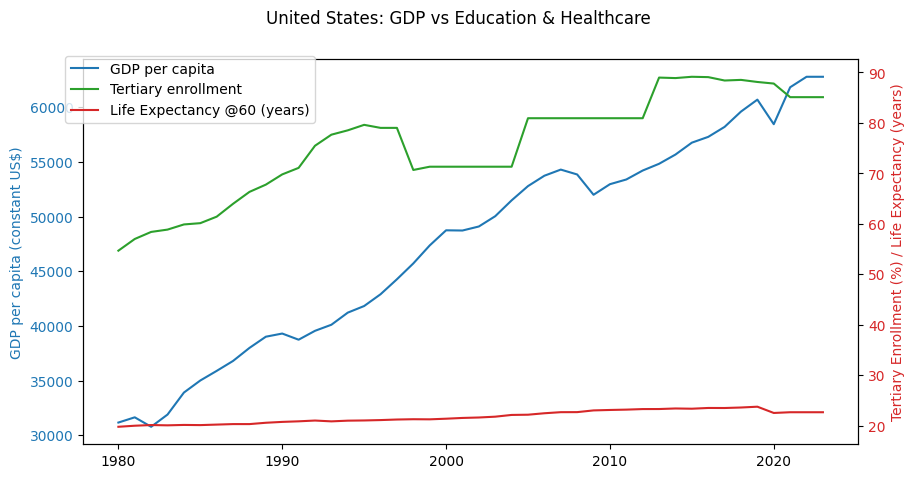

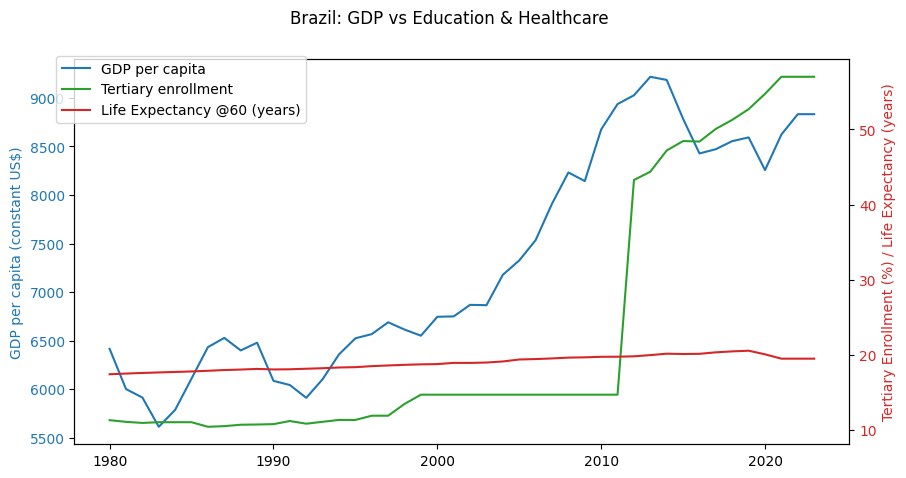

In [19]:
import matplotlib.pyplot as plt

countries = ["India", "United States", "Brazil"]

for c in countries:
    temp = df[df["REF_AREA_LABEL"] == c].copy()
    
    # ✅ Consistency fix: fill missing values so lines don’t break
    temp = temp.sort_values("YEAR")
    temp = temp.ffill().bfill()

    fig, ax1 = plt.subplots(figsize=(10,5))
    
    # GDP per capita on left axis
    ax1.plot(temp["YEAR"], temp["WB_GS_NY_GDP_PCAP_KD"], color="tab:blue", label="GDP per capita")
    ax1.set_ylabel("GDP per capita (constant US$)", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Education & healthcare on right axis
    ax2 = ax1.twinx()
    ax2.plot(temp["YEAR"], temp["WB_GS_SE_TER_ENRR"], color="tab:green", label="Tertiary enrollment")
    ax2.plot(temp["YEAR"], temp["WB_GS_SP_DYN_LE60_IN"], color="tab:red", label="Life Expectancy @60 (years)")
    ax2.set_ylabel("Tertiary Enrollment (%) / Life Expectancy (years)", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # Title & legend
    fig.suptitle(f"{c}: GDP vs Education & Healthcare")
    fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
    
    plt.show()